In [153]:
import math
import sys
import pickle
from math import log10 as log

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, classification_report
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder


In [90]:
# Load data
df_train_in = pd.read_csv('X_train.txt', header=None, delim_whitespace=True)
df_train_out = pd.read_csv('y_train.txt', header=None, delim_whitespace=True)

df_test_in = pd.read_csv('X_test.txt', header=None, delim_whitespace=True)
df_test_out = pd.read_csv('y_test.txt', header=None, delim_whitespace=True)

In [159]:
# Pre processing
'''
OneHotEncode    0–caminhada; 1 –subindoescadas; 2 –descendo escadas; 3 –sentado; 4 –em pé; 5 –deitado.
'''
encoder = OneHotEncoder(categories='auto')
encoder.fit(df_train_out)

df_train_out_scaled = df_train_out.to_numpy().flatten()
df_test_out_scaled = df_test_out.to_numpy().flatten() 

# Normalization
scaler = StandardScaler() 
scaler.fit(df_train_in)

df_train_in_scaled = scaler.transform(df_train_in)
df_test_in_scaled = scaler.transform(df_test_in)

In [96]:
def get_distance(inp, train, p):
    ''' Distancia de uma entrada de testes/validação para as entradas do treinamento '''
    return np.argsort(np.sum((train - inp)**p, axis=1)**(1/p))

def make_prediction(k, distances, train_outputs):
    '''k votes'''
    votes = [train_outputs[e] for e in distances[0:k]]
    unique, counts = np.unique(votes, return_counts=True)
    pred = dict(zip(unique, counts))
    return max(pred, key=lambda key: pred[key])
 

In [117]:
folds=5
kf = KFold(n_splits=folds, random_state=None, shuffle=False)
k_correct_pred = []

k_num = 500
k_mean = np.zeros(k_num)
k_sum = np.zeros(k_num)

for train_idx, validation_idx in kf.split(df_train_in_scaled):
    k_train_in, k_train_out = df_train_in_scaled[train_idx], df_train_out_scaled[train_idx]         # trainamento
    k_vali_in, k_vali_out = df_train_in_scaled[validation_idx], df_train_out_scaled[validation_idx] # validação
    
    # Calc Distance
    p = 2
    idx = 0
    distances_list = []
    for vali_in in k_vali_in:
        distances_list.append(get_distance(vali_in, k_train_in, p))

        sys.stdout.write("\r{:04d}".format(idx))
        sys.stdout.flush()
        idx += 1
    distances_list = np.array(distances_list)
    for k in range(1, k_num+1):# Buscando o melhor k
        validation_out_pred = []
        for distances in distances_list:
            validation_out_pred.append(make_prediction(k, distances, k_train_out))
        loss = np.array([(0 if t_==y_ else 1) for t_, y_ in zip(k_vali_out, validation_out_pred)])
        k_mean[k-1] += loss.mean()
        k_sum[k-1] += loss.sum()

k_mean = k_mean / folds
k_sum = k_sum / folds

1469

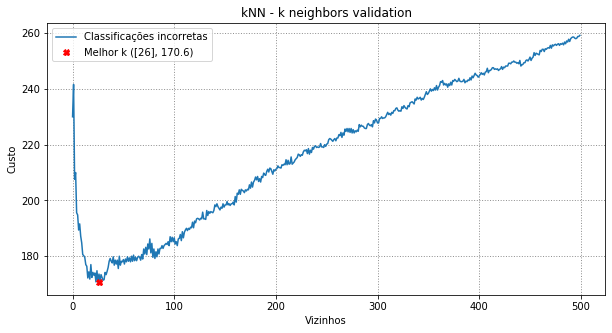

In [131]:
# Plot K 
min_k_mean =  np.amin(k_mean)
k = np.where(k_sum == np.amin(k_sum))[0].flatten() + 1
min_k_sum = np.amin(k_sum)

plt.figure(figsize=(10,5))
plt.grid(color='#919191', linestyle=':', linewidth=1)
plt.plot(k_sum, label='Classificações incorretas')
# plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--', label='Decisão aleatória')
plt.plot(k, min_k_sum,\
         'rx', marker="X",\
         label='Melhor k ({}, {:4})'.format(k,min_k_sum))
plt.title('kNN - k neighbors validation')
plt.xlabel('Vizinhos')
plt.ylabel('Custo')
# plt.xlim([-0.05, 1.0])
# plt.ylim([-0.05, 1.05])
plt.grid(True)
plt.legend()
plt.savefig('img2/knn', dpi=300)
plt.show()


In [130]:
np.where(k_sum == np.amin(k_sum))[0] + 1

array([26])

In [133]:
# Calc Distance
p = 2
distances_list = []
idx = 0
for test_in in df_test_in_scaled:
    distances_list.append(get_distance(test_in, df_train_in_scaled, p))
    sys.stdout.write("\r{}".format(idx))
    sys.stdout.flush()
    idx += 1
distances_list = np.array(distances_list)



2946k [26]


TypeError: only integer scalar arrays can be converted to a scalar index

In [169]:
##### Predict
print('k',k)
test_out_predict = []
for distances in distances_list:
    test_out_predict.append(make_prediction(k[0], distances, df_train_out_scaled))

cm = confusion_matrix(df_test_out.to_numpy(),test_out_predict)
print('Test')
print(cm)

k [26]
Test
[[489   2   5   0   0   0]
 [ 49 419   3   0   0   0]
 [ 67  59 294   0   0   0]
 [  0   2   0 387 100   2]
 [  0   0   0  21 511   0]
 [  0   0   0  10  18 509]]


In [168]:
# 0–caminhada; 1 –subindoescadas; 2 –descendo escadas; 3 –sentado; 4 –em pé; 5 –deitado.
print(classification_report(\
    np.array(df_test_out.to_numpy()),
    np.array(test_out_predict), digits=6,\
    target_names=['Caminhada','Subindo Escadas','Descendo Escadas','Sentado','em pé', 'Deitado']))

                  precision    recall  f1-score   support

       Caminhada   0.808264  0.985887  0.888283       496
 Subindo Escadas   0.869295  0.889597  0.879328       471
Descendo Escadas   0.973510  0.700000  0.814404       420
         Sentado   0.925837  0.788187  0.851485       491
           em pé   0.812401  0.960526  0.880276       532
         Deitado   0.996086  0.947858  0.971374       537

        accuracy                       0.885307      2947
       macro avg   0.897566  0.878676  0.880859      2947
    weighted avg   0.896129  0.885307  0.883887      2947



In [150]:
k

array([26])

In [160]:
min(df_test_out.to_numpy())

array([1])